<a href="https://colab.research.google.com/github/pdoren/analisis-estadistico-con-Python-G105/blob/main/Desaf%C3%ADo_7_Preprocesamiento_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío 7 - Preprocesamiento de datos

**Nombre**: Pablo Saavedra <br />
**Curso**: Machine Learning (G105)


---

### Importación de librerías

In [234]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

import re
from datetime import datetime
from collections import Counter

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor


# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [143]:
def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto'):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


def plot_corr(
    df,
    method="pearson",
    figsize=(12, 10),
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
):
    """
    Muestra un heatmap de la matriz de correlación de un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada
    method : str
        Método de correlación: 'pearson', 'spearman', 'kendall'
    figsize : tuple
        Tamaño de la figura
    annot : bool
        Mostrar valores numéricos en el heatmap
    cmap : str
        Colormap
    vmin, vmax : float
        Límites de la escala de correlación
    """

    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include="number")

    if df_num.shape[1] < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Calcular correlación
    corr = df_num.corr(method=method)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Matriz de correlación ({method})", fontsize=14)
    plt.tight_layout()
    plt.show()

## 1 y 2. Análisis de Datos y Transformación Inicial de Datos

1. Realiza un análisis de calidad de datos, revisando aspectos básicos y selecciona un primer conjunto de variables a eliminar. Luego de ello, realiza un análisis exploratorio inicial considerando gráficos de distribuciones de las diferentes variables, y concluye al respecto. Si observas algo raro respecto a los tipos de variables debes proponer algún tratamiento.

2. Transformación Inicial de Datos: Las diferentes columnas que son datos de texto deben ser transformadas a numéricas para poder explorarlas de mejor forma por ejemplo:

   a. User Rating: Extraer el número correspondiente al rating

   b. Number of Votes: Convertir en número

   c. Year: Extraer el año de inicio del anime
   
   d. Otros. Aplica algún criterio para saber qué variables deben ser transformadas en primera instancia.

#### Carga de datos

In [144]:
_df = pd.read_excel('/content/drive/MyDrive/imdb_anime.xlsx')


In [145]:
df = _df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45717 entries, 0 to 45716
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            45717 non-null  object
 1   Genre            45717 non-null  object
 2   User Rating      25009 non-null  object
 3   Number of Votes  25009 non-null  object
 4   Runtime          32549 non-null  object
 5   Year             45591 non-null  object
 6   Summary          23547 non-null  object
 7   Stars            13676 non-null  object
 8   Certificate      28694 non-null  object
 9   Metascore        341 non-null    object
 10  Gross            25009 non-null  object
 11  Episode          45717 non-null  object
 12  Episode Title    34910 non-null  object
dtypes: object(13)
memory usage: 4.5+ MB


> **Title**: Se convierte en número

In [146]:
# Convertir Title a un código númerico
le = LabelEncoder()
df["Title"] = df["Title"].astype(str)
df["Title"] = le.fit_transform(df["Title"])

> **Genre**: Para el genero se puede convertir la columna en multi-hot encoding

In [147]:
# Normalizar texto y separar
s = (df["Genre"]
     .fillna("")
     .str.lower()
     .str.replace(" ", "", regex=False)
)

# Crear multi-hot
genre_dummies = s.str.get_dummies(sep=",")

df = pd.concat([df.drop(columns=["Genre"]), genre_dummies], axis=1)

> **User Rating**: Debido a que el objetivo es obtener un modelo para predecir el User Rating es necesario eliminar los registros nulos (no se puede aprender sin un target, aprendizaje supervisado)

In [148]:
# Convertir a número el User Rating
df['User Rating'] =  pd.to_numeric(df["User Rating"], errors="coerce")   # Convertir a número
df = df.dropna(subset=["User Rating"])  # Borrar registros NaN

> **Number of Votes**: Convertir a número

In [149]:
df['Number of Votes'] = pd.to_numeric(df['Number of Votes'], errors='coerce') # Convertir a números

> **Runtime**: para los valores NaN se reemplazara su valor por la media del conjunto

In [150]:
# Convertir a float
df["Runtime"] = df["Runtime"].str.replace(" min", "").str.replace("Runtime", "NaN").str.replace(",", "")
df["Runtime"] = pd.to_numeric(df["Runtime"], errors="coerce")

# Reemplazar los nulos por la media
imputer = SimpleImputer(strategy="mean")
df["Runtime"] = imputer.fit_transform(df[["Runtime"]]).ravel()

> **Year**: Convertir en 2 columnas de año de inicio y final

In [151]:
CURRENT_YEAR = datetime.now().year

YEAR_REGEX = re.compile(r"\b(18\d{2}|19\d{2}|20\d{2})\b")

def extract_start_end_year(value):
    """
    Extrae año inicio y fin desde formatos IMDb-like.
    Devuelve (start_year, end_year)
    """
    if pd.isna(value):
        return pd.Series([None, None])

    # Caso: número negativo (-2023)
    if isinstance(value, (int, float)):
        year = abs(int(value))
        return pd.Series([year, year])

    text = str(value)

    # Extraer todos los años válidos
    years = [int(y) for y in YEAR_REGEX.findall(text)]

    if not years:
        return pd.Series([None, None])

    # Un solo año entonces mismo inicio y fin
    if len(years) == 1:
        return pd.Series([years[0], years[0]])

    start_year = years[0]
    end_year = years[-1]

    # Detectar rangos abiertos "(1999– )"
    if re.search(r"[–-]\s*\)", text) or re.search(r"[–-]\s*$", text):
        end_year = CURRENT_YEAR

    return pd.Series([start_year, end_year])

df[["start_year", "end_year"]] = df["Year"].apply(extract_start_end_year)
df = df.drop(columns=["Year"])


> **Sumary**: Se borra porque no aporta como información al modelo

In [152]:
df = df.drop(columns=["Summary"])

> **Stars**: Se generaran columnas con variables compactas a partir de los datos de los nombres

In [153]:
# separar nombres
df["Stars"] = (
    df["Stars"]
    .fillna("")
    .apply(lambda x: [n.strip() for n in x.split(",") if n.strip()])
)

# conteo global
conteo = Counter(n for sub in df["Stars"] for n in sub)

# Variables compactas

# Cantidad de nombres en el registro
df["n_stars"] = df["Stars"].apply(len)

# Tiene nombres
df["has_stars"] = (df["n_stars"] > 0).astype(int)

# Suma de frecuencia de los nombres
df["pop_total"] = df["Stars"].apply(
    lambda x: sum(conteo[n] for n in x) if x else 0
)

# Eliminar Stars
df = df.drop(columns=["Stars"])

> **Certificate**: Se convierte el código un código númerico

In [154]:
le = LabelEncoder()
df["Certificate"] = df["Certificate"].astype(str)
df["Certificate"] = le.fit_transform(df["Certificate"])

> **Metascore**: Existen muy pocos elementos y se procede a eliminar

In [155]:
df = df.drop(columns=["Metascore"])

> **Gross**: Se convierte en número

In [156]:
# Convertir a float
df["Gross"] = pd.to_numeric(df["Gross"], errors="coerce")

# Reemplazar los nulos por la media
imputer = SimpleImputer(strategy="mean")
df["Gross"] = imputer.fit_transform(df[["Gross"]]).ravel()

> **Episode Title**: Se elimina debido que solo identifica al registro y no será un aporte para el modelo

In [157]:
df = df.drop(columns=["Episode Title"])

> Revisión de estadísticas

In [158]:
df.describe()

,Title,User Rating,Number of Votes,Runtime,Certificate,Gross,action,adventure,animation,biography,...,sport,talk-show,thriller,war,western,start_year,end_year,n_stars,has_stars,pop_total
count,"25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00",...,"25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00","25,008.00"
mean,"4,722.95",7.22,"2,983.80",31.64,23.81,"2,983.80",0.62,0.50,1.00,0.00,...,0.01,0.00,0.00,0.00,0.00,"2,002.16","2,005.01",1.24,0.32,66.49
std,"2,791.21",1.00,"31,682.38",29.78,5.42,"31,682.38",0.48,0.50,0.01,0.03,...,0.09,0.00,0.06,0.03,0.00,13.38,13.68,1.82,0.47,139.98
min,0.00,1.00,5.00,1.00,0.00,5.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,"1,907.00","1,907.00",0.00,0.00,0.00
25%,"2,054.00",6.70,22.00,23.00,21.00,22.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,"1,996.00","1,996.00",0.00,0.00,0.00
50%,"4,878.00",7.30,84.00,24.00,23.00,84.00,1.00,1.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,"2,003.00","2,007.00",0.00,0.00,0.00
75%,"6,971.50",7.80,413.00,31.64,26.00,413.00,1.00,1.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,"2,012.00","2,017.00",4.00,1.00,75.00
max,"9,850.00",9.90,"1,162,284.00","1,271.00",32.00,"1,162,284.00",1.00,1.00,1.00,1.00,...,1.00,0.00,1.00,1.00,0.00,"2,023.00","2,024.00",4.00,1.00,811.00


> De los datos estadísticos se puede decir:
> - Number of Votes y Gross tienen estadísticas similares, probablemente son iguales
> - El Runtime y Number of Votes tienen una alta disperción (desviación estándar)

In [159]:
(df["Number of Votes"] == df["Gross"]).all()  # Si es True ambas columnas tienen los mismos valores

np.True_

> Se elimina la columna Gross porque los datos están duplicados en la columna Number of Votes

In [160]:
# Se elimina la columna Gross
df = df.drop(columns=["Gross"])

> Eliminar los registros duplicados

In [161]:
df = df.drop_duplicates()

> Distribución de los datos

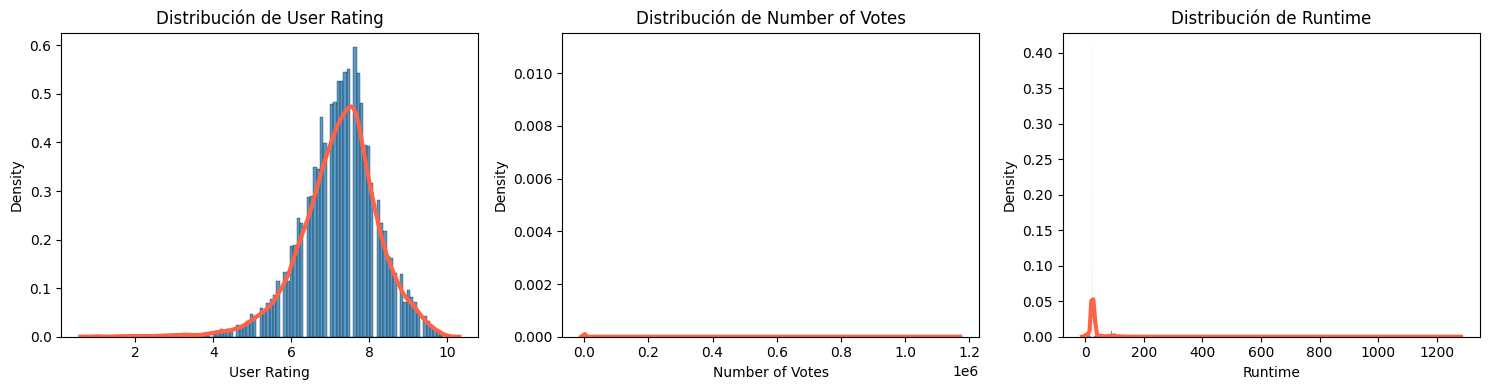

In [162]:
variables_cuantitativas = ['User Rating', 'Number of Votes', 'Runtime']
plot_hist(df, variables_cuantitativas)

> La distribución de los datos indican:
> - El User Rating tiene una distribución Normal centrada en 7.2
> - Number of Votes tiene una cola larga, distribución asimétrica
> - El Metascore y Runtime está concentrado en la media
> - Las colas largas indican la exitencia de outliers

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


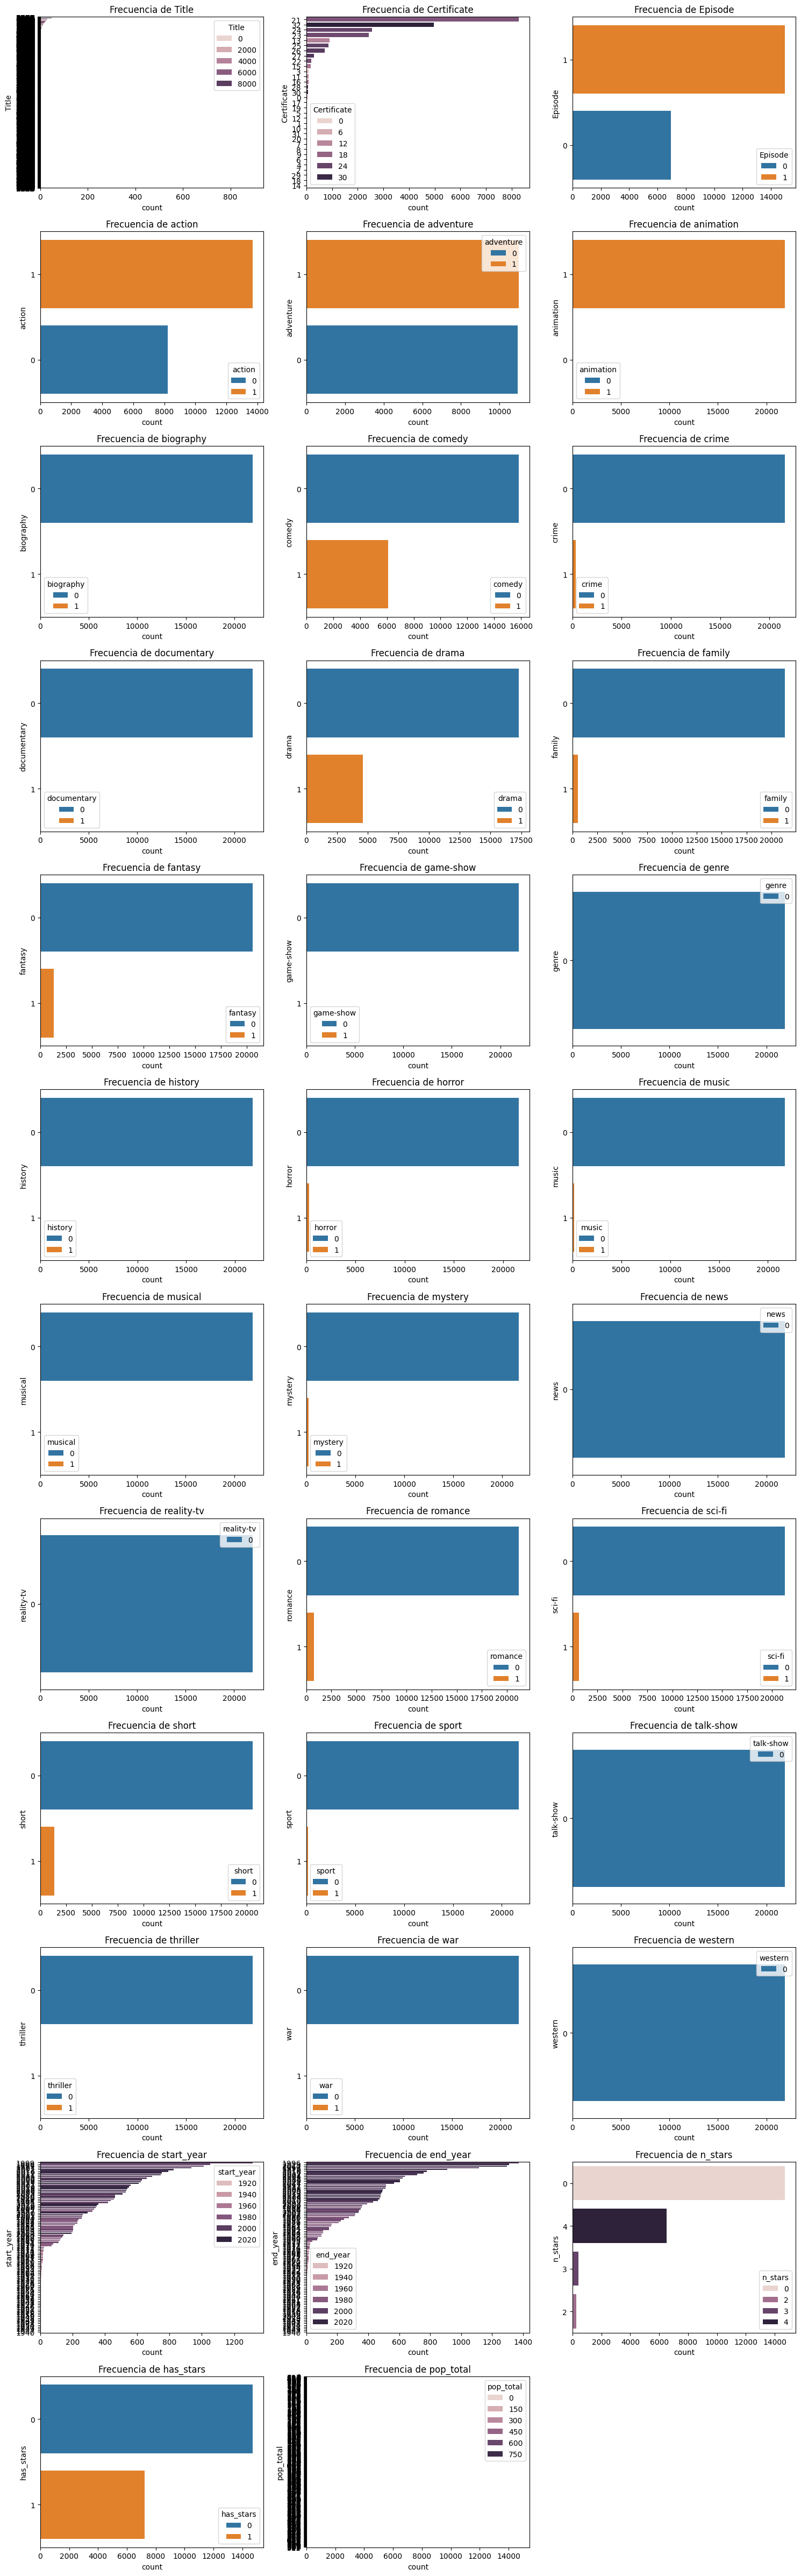

In [163]:
variables_cualitativas = resultado = [x for x in df.columns.tolist() if x not in variables_cuantitativas]
plot_count(df, variables_cualitativas)

In [173]:
# Se eliminan las columnas con un solo valor
df = df.drop(columns=["genre", "news", "reality-tv", "talk-show", "western"])

## 3. Revisión de outliers

Ahora que tienes variables numéricas revisa la distribución y utiliza algún método para encontrar outliers, por ejemplo IQR o Z-score.

> Para eliminar los outliers se utilizará el método IQR

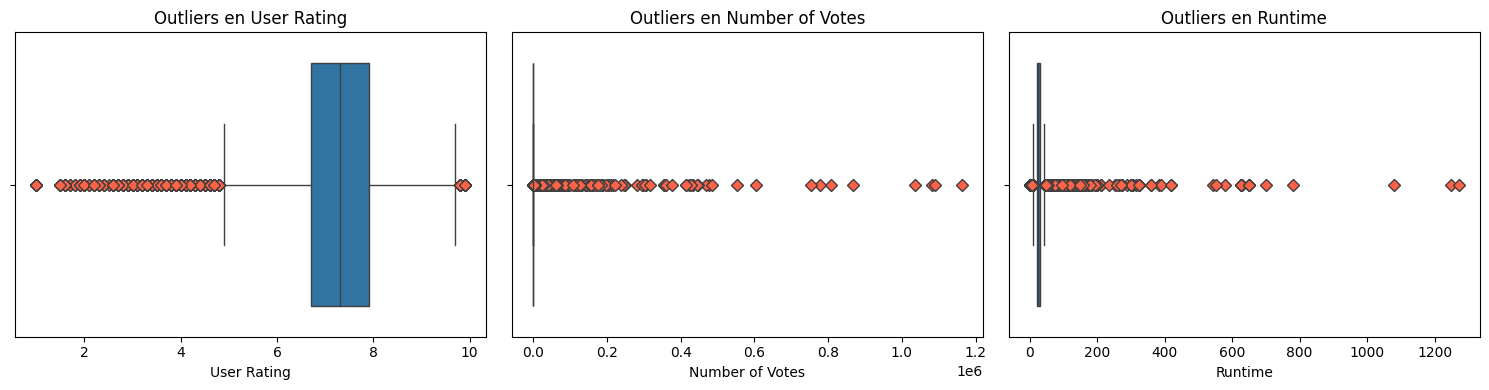

In [164]:
plot_outliers(df, variables_cuantitativas)

In [176]:
df_limpio = clean_outliers(df, variables_cuantitativas, _k=3.0)  # método de limpieza usando IQR con K=3.0 (para no liminar tantos datos)

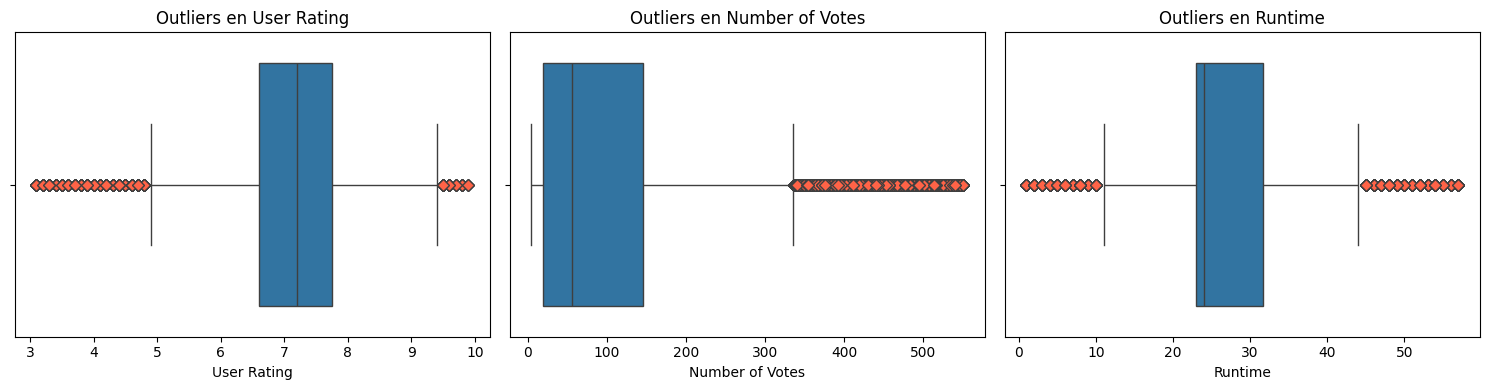

In [177]:
plot_outliers(df_limpio, variables_cuantitativas)

In [178]:
print(f"Se eliminó el {100*(1 - (len(df_limpio)/len(df))):.2f}% de registros")

Se eliminó el 24.56% de registros


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21924 entries, 0 to 45716
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            21924 non-null  int64  
 1   User Rating      21924 non-null  float64
 2   Number of Votes  21924 non-null  int64  
 3   Runtime          21924 non-null  float64
 4   Certificate      21924 non-null  int64  
 5   Episode          21924 non-null  object 
 6   action           21924 non-null  int64  
 7   adventure        21924 non-null  int64  
 8   animation        21924 non-null  int64  
 9   biography        21924 non-null  int64  
 10  comedy           21924 non-null  int64  
 11  crime            21924 non-null  int64  
 12  documentary      21924 non-null  int64  
 13  drama            21924 non-null  int64  
 14  family           21924 non-null  int64  
 15  fantasy          21924 non-null  int64  
 16  game-show        21924 non-null  int64  
 17  history          

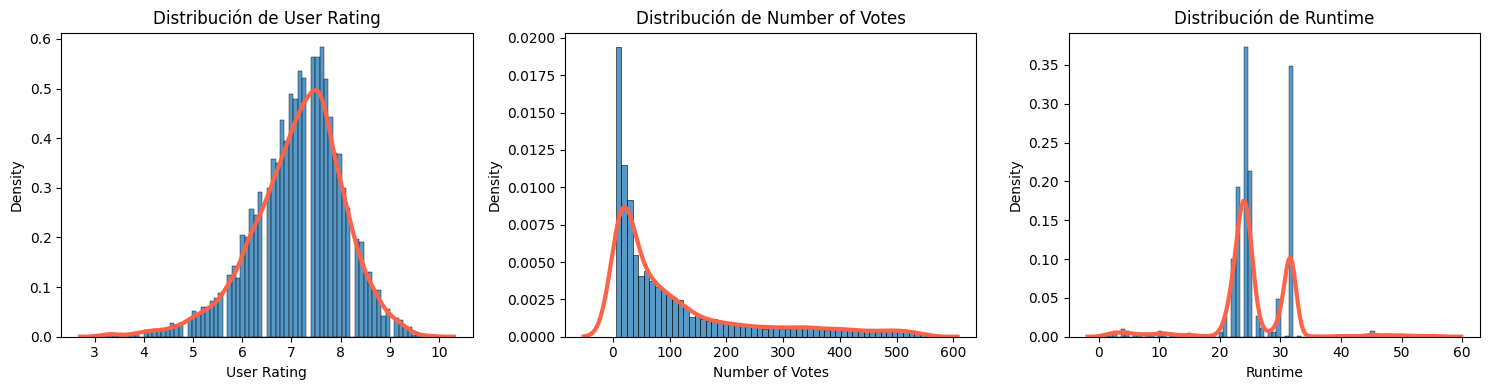

In [180]:
plot_hist(df_limpio, variables_cuantitativas)

## 4. Transformación de variables finales

Realiza un pequeño análisis de distribuciones y transforma las variables aplicando transformaciones como logaritmo o get_dummies para extraer las diferentes categorías.  Genera una estrategia para lidiar con los valores nulos y crea las variables que te parezcan necesarias.

> Esto ya fue generado para los generos y las estrellas en la sección 1 y 2
> - **Genres**: Se generó multi-hot encoding con get_dummies
> - **Stars**: Se generaron variables compactas, es decir, nuevas variables utilizando algunas operaciones estadísticas sobre los nombres contenidos en la columna Stars: n_stars. has_stars, pop_total

## 5. Análisis de Correlaciones

Genera un análisis de correlaciones de las variables. No es necesario que apliques todos los métodos vistos en clases, basta que argumentes bien cuál utilizarás y por qué, y si necesitas algo más. La idea es generar gráficos para entender la relación entre las diferentes variables, poniendo foco en la variable objetivo User Rating.

> Se calcula la correlación Spearman debido a que las variables NO son normales ni lineales

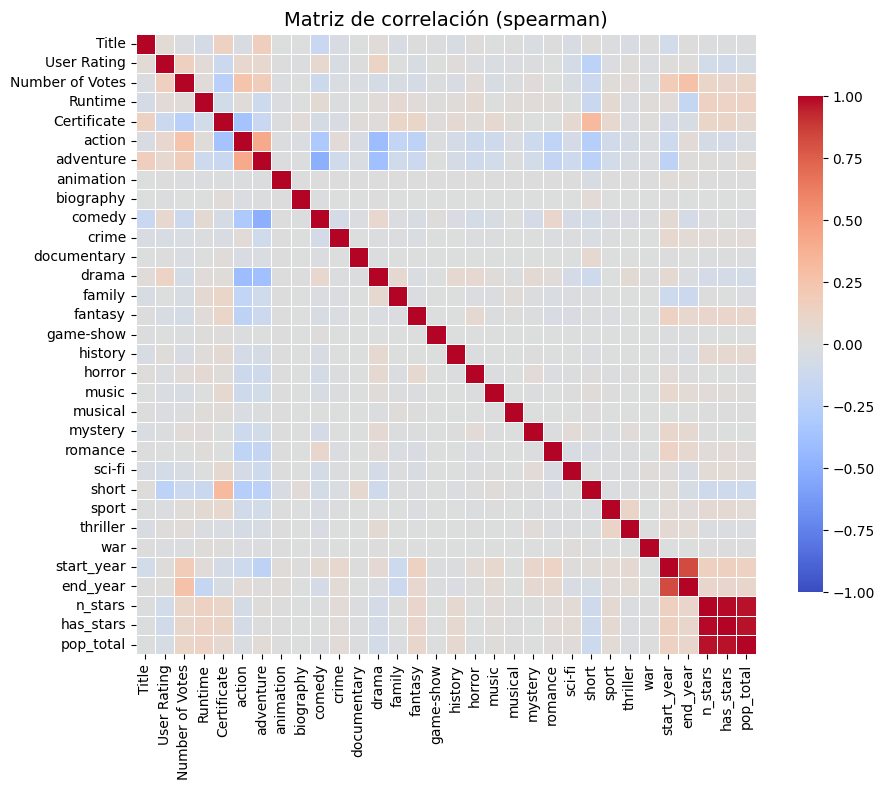

In [187]:
# Mostrar un gráfico con la matriz de correlación
plot_corr(df_limpio, method="spearman",
    figsize=(10, 8))

In [188]:
corr_spearman = df.select_dtypes(include="number").corr(method="spearman")
print(corr_spearman)

                 Title  User Rating  Number of Votes  Runtime  Certificate  \
Title             1.00         0.02            -0.04    -0.04         0.09   
User Rating       0.02         1.00             0.27    -0.04        -0.17   
Number of Votes  -0.04         0.27             1.00     0.09        -0.30   
Runtime          -0.04        -0.04             0.09     1.00        -0.05   
Certificate       0.09        -0.17            -0.30    -0.05         1.00   
action           -0.04         0.14             0.24    -0.02        -0.32   
adventure         0.12         0.14             0.23    -0.10        -0.16   
animation        -0.01         0.00            -0.01    -0.02        -0.02   
biography        -0.01        -0.02             0.01     0.02         0.02   
comedy           -0.10         0.01            -0.16     0.02        -0.02   
crime            -0.05        -0.02             0.03     0.00        -0.03   
documentary      -0.00         0.00            -0.02     0.01   

> - La popularidad influye moderadamente en el Rating (Number of Votes: 0.27).
> - Géneros con mayor correlación positiva:
>    1. action: 0.14
>    2. adventure: 0.14
> - Género con mayor correlación negativa: short: -0.20
> - La clasificación no determinan directamente el Rating (Certificate: -0.17).
> - User Rating no depende fuertemente de una sola variable.

In [171]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16539 entries, 129 to 45716
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            16539 non-null  int64  
 1   User Rating      16539 non-null  float64
 2   Number of Votes  16539 non-null  int64  
 3   Runtime          16539 non-null  float64
 4   Certificate      16539 non-null  int64  
 5   Episode          16539 non-null  object 
 6   action           16539 non-null  int64  
 7   adventure        16539 non-null  int64  
 8   animation        16539 non-null  int64  
 9   biography        16539 non-null  int64  
 10  comedy           16539 non-null  int64  
 11  crime            16539 non-null  int64  
 12  documentary      16539 non-null  int64  
 13  drama            16539 non-null  int64  
 14  family           16539 non-null  int64  
 15  fantasy          16539 non-null  int64  
 16  game-show        16539 non-null  int64  
 17  genre          

## 6. Genera una función

Genera una función que resuma todo el procesamiento necesario para el dataset, que lea el dataset original y entregue un dataset ya tratado, con las columnas transformadas y creadas.

In [190]:
def clean_data(_df):
    df = _df.copy()

    # --- Helpers ---
    def label_encode(col):
        le = LabelEncoder()
        return le.fit_transform(df[col].astype(str))

    def to_num(col):
        df[col] = pd.to_numeric(df[col], errors="coerce")

    def impute_mean(col):
        imp = SimpleImputer(strategy="mean")
        df[col] = imp.fit_transform(df[[col]]).ravel()

    # --- Title / Certificate (label encoding) ---
    df["Title"] = label_encode("Title")
    df["Certificate"] = label_encode("Certificate")

    # --- Genre (multi-hot) ---
    s = (df["Genre"].fillna("")
                  .str.lower()
                  .str.replace(" ", "", regex=False))
    df = pd.concat([df.drop(columns=["Genre"]), s.str.get_dummies(sep=",")], axis=1)

    # --- Target y numéricos básicos ---
    to_num("User Rating")
    df = df.dropna(subset=["User Rating"])
    to_num("Number of Votes")

    # --- Runtime: limpiar texto -> num -> imputar ---
    df["Runtime"] = (df["Runtime"].astype(str)
                               .str.replace(" min", "", regex=False)
                               .str.replace(",", "", regex=False)
                               .str.strip())
    to_num("Runtime")
    impute_mean("Runtime")

    # --- Year -> start/end, drop Year ---
    df[["start_year", "end_year"]] = df["Year"].apply(extract_start_end_year)
    df = df.drop(columns=["Year"])

    # --- Drop columnas que no usas ---
    df = df.drop(columns=["Summary", "Metascore", "Episode Title"], errors="ignore")

    # --- Stars: features compactas ---
    df["Stars"] = (df["Stars"].fillna("")
                             .apply(lambda x: [n.strip() for n in str(x).split(",") if n.strip()]))
    conteo = Counter(n for sub in df["Stars"] for n in sub)

    df["n_stars"] = df["Stars"].apply(len)
    df["has_stars"] = (df["n_stars"] > 0).astype(int)
    df["pop_total"] = df["Stars"].apply(lambda xs: sum(conteo[n] for n in xs) if xs else 0)
    df = df.drop(columns=["Stars"])

    # --- Gross (si no lo vas a usar, elimínalo directo) ---
    # Si quisieras usarlo, descomenta estas líneas y NO lo borres después:
    # to_num("Gross"); impute_mean("Gross")
    df = df.drop(columns=["Gross"], errors="ignore")

    # --- Limpieza final ---
    df = df.drop_duplicates()

    # columnas constantes (según tu análisis)
    df = df.drop(columns=["genre", "news", "reality-tv", "talk-show", "western"], errors="ignore")

    # outliers
    df = clean_outliers(df, variables_cuantitativas, _k=3.0)

    return df


In [205]:
df_preprocesado = clean_data(_df)

In [206]:
df_preprocesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16539 entries, 129 to 45716
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            16539 non-null  int64  
 1   User Rating      16539 non-null  float64
 2   Number of Votes  16539 non-null  int64  
 3   Runtime          16539 non-null  float64
 4   Certificate      16539 non-null  int64  
 5   Episode          16539 non-null  object 
 6   action           16539 non-null  int64  
 7   adventure        16539 non-null  int64  
 8   animation        16539 non-null  int64  
 9   biography        16539 non-null  int64  
 10  comedy           16539 non-null  int64  
 11  crime            16539 non-null  int64  
 12  documentary      16539 non-null  int64  
 13  drama            16539 non-null  int64  
 14  family           16539 non-null  int64  
 15  fantasy          16539 non-null  int64  
 16  game-show        16539 non-null  int64  
 17  history        

## 7. Selección de Variables

A partir de las columnas que obtuviste realiza una selección de variables según los siguientes métodos:

1.  Filtros basados en correlaciones.
2.  Forward Selection.

Compara ambos métodos y responde si coincide lo resultante con lo obtenido en el análisis exploratorio.

### Selección por filtro de correlación

In [224]:
def select_variables_corr(_df_data, target, umbral=0.7, method="spearman"):
  # Quitar target y quedarnos solo con numéricas
  X = _df_data.drop(columns=[target]).select_dtypes(include="number")

  # Matriz de correlación
  corr = X.corr(method=method).abs()

  # Triángulo superior
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

  # Variables altamente correlacionadas entre sí
  to_drop = [col for col in upper.columns if any(upper[col] > umbral)]

  # Columnas seleccionadas
  return X.drop(columns=to_drop).columns

selected_features_corr = select_variables_corr(df_preprocesado, "User Rating", 0.1)

print("Características seleccionadas por correlaciones:")
print(selected_features_corr)

Características seleccionadas por correlaciones:
Index(['Title', 'Number of Votes', 'Runtime', 'animation', 'biography',
       'documentary', 'game-show', 'history', 'musical', 'sport', 'war'],
      dtype='object')


### Selección por Forward Selection

In [220]:
def select_variables_forward(_df_data, target, n_features_to_select=3):
  # Obtención de los datos y el target
  X = _df_data.drop(columns=[target])
  y = _df_data[target]

  # Modelo para la regresión
  model = Ridge()
  sfs = SequentialFeatureSelector(
      model,
      n_features_to_select=n_features_to_select,
      direction="forward",
      scoring="neg_mean_absolute_error",  # o "r2", "neg_mean_squared_error"
      cv=5,
      n_jobs=-1
  )
  # Entrenamiento para la selección
  sfs.fit(X, y)

  # Columnas seleccionadas
  return X.columns[sfs.support_]

selected_features_forward = select_variables_forward(df_preprocesado, "User Rating", 7)

print("Características seleccionadas por Forward Selection:")
print(selected_features_forward)


Características seleccionadas por Forward Selection:
Index(['Number of Votes', 'Runtime', 'Certificate', 'Episode', 'comedy',
       'drama', 'short'],
      dtype='object')


### Evaluación de ambos métodos de selección

In [227]:
# Evaluación líneal

def evaluate_feature_set(df, target, features, cv=5, random_state=42):
  X = df[list(features)]
  y = df[target]

  pipe = Pipeline([
      ("imputer", SimpleImputer(strategy="median")),
      ("scaler", StandardScaler()),
      ("model", Ridge())
  ])

  cv_split = KFold(n_splits=cv, shuffle=True, random_state=random_state)

  scores = cross_validate(
      pipe, X, y,
      cv=cv_split,
      scoring={
          "mae": "neg_mean_absolute_error",
          "rmse": "neg_root_mean_squared_error",
          "r2": "r2"
      },
      n_jobs=-1
  )

  return {
      "n_features": len(features),
      "MAE_mean": -scores["test_mae"].mean(),
      "MAE_std":  scores["test_mae"].std(),
      "RMSE_mean": -scores["test_rmse"].mean(),
      "RMSE_std":  scores["test_rmse"].std(),
      "R2_mean": scores["test_r2"].mean(),
      "R2_std":  scores["test_r2"].std(),
  }

In [231]:
# Selección de características
target = "User Rating"
selected_features_forward = select_variables_forward(df_preprocesado, target, 11)
selected_features_corr    = select_variables_corr(df_preprocesado, target, umbral=0.1, method="spearman")

res_forward = evaluate_feature_set(df_preprocesado, target, selected_features_forward)
res_corr    = evaluate_feature_set(df_preprocesado, target, selected_features_corr)

print("Forward Selection:", res_forward)
print("Correlation Filter:", res_corr)

Forward Selection: {'n_features': 11, 'MAE_mean': np.float64(0.6512007238571138), 'MAE_std': np.float64(0.010149916010333718), 'RMSE_mean': np.float64(0.8566652441017932), 'RMSE_std': np.float64(0.01671335437602598), 'R2_mean': np.float64(0.15515642125919565), 'R2_std': np.float64(0.01774939920309481)}
Correlation Filter: {'n_features': 11, 'MAE_mean': np.float64(0.7127355437956805), 'MAE_std': np.float64(0.007957121125572238), 'RMSE_mean': np.float64(0.9230770623524569), 'RMSE_std': np.float64(0.012183903641889125), 'R2_mean': np.float64(0.019088328456242996), 'R2_std': np.float64(0.005854668636469931)}


### Conclusiones con Evaluación Líneal (Ridge):

> - Forward Selection tiene menor error absoluto y error cuadrático.
> - Forward Selection optimiza directamente el error respecto a User Rating. Mientras que el filtro por correlación solo elimina redundancia entre features, sin considerar el target.

In [235]:
# Evaluación no-lineal

def evaluate_feature_set_rf(
    df,
    target,
    features,
    cv=5,
    random_state=42,
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5
):
    X = df[list(features)]
    y = df[target]

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1
        ))
    ])

    cv_split = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    scores = cross_validate(
        pipe,
        X,
        y,
        cv=cv_split,
        scoring={
            "mae": "neg_mean_absolute_error",
            "rmse": "neg_root_mean_squared_error",
            "r2": "r2"
        },
        n_jobs=-1
    )

    return {
        "model": "RandomForest",
        "n_features": len(features),
        "MAE_mean": -scores["test_mae"].mean(),
        "MAE_std":  scores["test_mae"].std(),
        "RMSE_mean": -scores["test_rmse"].mean(),
        "RMSE_std":  scores["test_rmse"].std(),
        "R2_mean": scores["test_r2"].mean(),
        "R2_std":  scores["test_r2"].std(),
    }

In [236]:
res_rf_forward = evaluate_feature_set_rf(
    df_preprocesado,
    target="User Rating",
    features=selected_features_forward
)

res_rf_corr = evaluate_feature_set_rf(
    df_preprocesado,
    target="User Rating",
    features=selected_features_corr
)

print("RF + Forward Selection:", res_rf_forward)
print("RF + Correlation Filter:", res_rf_corr)

RF + Forward Selection: {'model': 'RandomForest', 'n_features': 11, 'MAE_mean': np.float64(0.5236049942087471), 'MAE_std': np.float64(0.004145854253442472), 'RMSE_mean': np.float64(0.712067491375263), 'RMSE_std': np.float64(0.007815815895807229), 'R2_mean': np.float64(0.4162146346473376), 'R2_std': np.float64(0.008098050714675922)}
RF + Correlation Filter: {'model': 'RandomForest', 'n_features': 11, 'MAE_mean': np.float64(0.4901191106204994), 'MAE_std': np.float64(0.006782937181093951), 'RMSE_mean': np.float64(0.679356766482203), 'RMSE_std': np.float64(0.01147230549437184), 'R2_mean': np.float64(0.4686506365151894), 'R2_std': np.float64(0.01054364410773182)}


### Conclusiones con Evaluación NO Líneal (RF):

> - Random Forest mejora drásticamente el rendimiento (casi el triple en R2). La relación entre features y User Rating es no lineal.
> - El filtro por correlación ahora supera al Forward Selection.
> - El filtro por Correlación conserva variables complementarias que no son linealmente fuertes, pero sí útiles en árboles.
> - Forward Selection (con Ridge) está sesgado a relaciones lineales, y por eso descarta señal no lineal que RF aprovecha. Se podría mejorar la selección forward usando un modelo no líneal como Random Forest (RF).